In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt

In [2]:
## !! CHANGE ME !! ##
os.chdir('C:\\ali\\packages\\s2p-lbm')

In [4]:
from utils import tiff_utils as tfu

In [5]:
from dask import array as darr

## Convenience functions

### Loading raw tiffs

In [6]:
## !! CHANGE ME !! ## 
example_tif_dir = 'E:\\Subjects\\AH007\\2022-03-31\\1'

In [7]:
tif_paths = tfu.get_tif_paths(example_tif_dir)
example_tif_path = tif_paths[0]

In [8]:
print(example_tif_path)

E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif


In [9]:
# loads lbm tif files directly into memory 
# If you provide a list of paths, it will load all files and concatenate them along the time axis
# Loads all strips and stitch them back together into one large image, and de-interleaves the planes
# You can specify how many planes you want to load at once. 
# Plane 0 is deepest, 1 is second deepest, 30 is shallowest (not the wacky ScanImage channel order)
# Optionally applies a spatiotemporal filter to remove 200 Hz line noise (see usage later in this notebook)
mov = lbmio.load_and_stitch_tifs([example_tif_path], planes = n.arange(15),
                                 verbose=True, n_proc = 15, filt=None)

Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif
Loaded 1 files, total 3.41 GB


In [10]:
print(mov.shape)

# num planes, timepoints, ypix, xpix
nz, nt, ny, nx = mov.shape

(15, 100, 1202, 1015)


### Get tiff metadata

In [11]:
volume_rate = tfu.get_vol_rate(example_tif_path)
print(volume_rate)

2.7984


In [12]:
scanner_frequency = tfu.get_tif_tag(example_tif_path, 'SI.hScan2D.scannerFrequency', number=True)
print(scanner_frequency)

12027.5


### Displaying tiffs

In [13]:
im3d = mov.mean(axis=1)

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x249a9205400>)

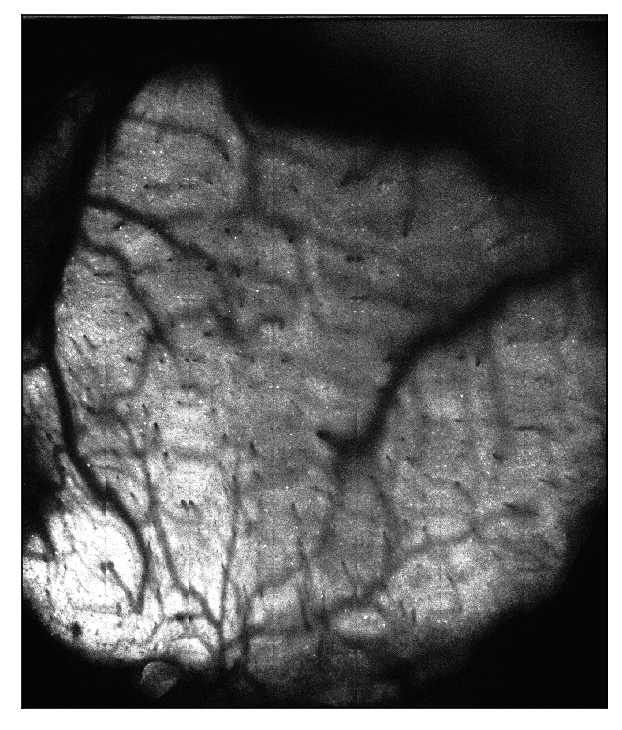

In [14]:
# Display plane 10
tfu.show_tif(im3d[9])

## Initial pass

In [28]:
job_params = {
    'exp_str' : "test_experiment_002", #unique ID for the experiment
    'planes' : n.arange(5,15), # planes to analyze
    'fs' : volume_rate,
    'notch_filt' : {"f0" : 200, 'Q' : 1, 'line_freq' : scanner_frequency}, # notch filter to remove line noise. 
                                                                          # set to none if you don't need it
    
    'subtract_crosstalk' : True, # subtract crosstalk from lower 15 planes to upper 15 planes
    'override_crosstalk' : 0.21, # set to None to try to compute it from data
                                # I usually compute it once and use the same value
    
    'nonrigid' : True, # do nonrigid registration
    'smooth_sigma' : 1.15, 'maxregshift' : 0.15, 'reg_filter_pcorr': 1, #s2p reg params, works fine for me
    'generate_sample_registered_bins' : False, # create and save some example registered binaries in the initial phase
                                              # for debugging and comparing parameters
    
    'dtype' : n.float32, 
    'n_init_files' : 3, # number of files to use for the initialization pass to compute registration
                        # reference image, as well the plane-to-plane shifts & crosstalk. Should be 2+.
                        # Takes ~ 15 ish minutes per file
    'init_file_pool' : None,  # set to None to sample n_init_files from all tifs for initialization files
    'init_file_sample_method' : 'even', # 'random' for picking the initialization files randomly, 'even' for even spacing
    
    'total_tifs_to_analyze' : None, # None to analyze all tifs, set to an int to stop processing after XX tifs
    'tif_batch_size' : 1, # number of tifs to analyze at once. Doesn't make it significantly faster, so leave at 1.
    'load_from_binary' : False, # if you've already registered them, you can load tifs from binaries
    
}

In [29]:
## !! Change Me !! ##
analysis_dir = 'Y:\\analysis\\example'
os.makedirs(analysis_dir,exist_ok=True)

In [30]:
tifs = tfu.get_tif_paths(example_tif_dir)

In [31]:
job = Job(analysis_dir, job_params['exp_str'], job_params, tifs, verbosity=10, exist_ok=True, create=True)
# job = Job(analysis_dir, job_params['exp_str'], create = False) # use this if job has already been created

Job directory Y:\analysis\example\s3d-test_experiment_002 already exists
Loading job directory for test_experiment_002 in Y:\analysis\example
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
      Updated params file: Y:\analysis\example\s3d-test_experiment_002\params.npy


In [32]:
job.run_init_pass()

Launching initial pass
Saving summary to Y:\analysis\example\s3d-test_experiment_002\summary\summary.npy
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00061.tif
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00121.tif
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00181.tif
Loaded 3 files, total -1.00 GB
   Subtracting crosstalk with forced coefficient 0.210
   Building ops file
Setting smooth_sigma: 1.15
Setting maxregshift: 0.15
Setting Ly: 1202
Setting Lx: 1015
Setting nonrigid: True
   Aligning planes and calculating reference images
   Computing reference images
        Computed reference for plane 0
        Computed reference for plane 1
        Computed reference for plane 2
        Computed reference for plane 3
        Computed reference for plane 4
        Computed reference for plane 5
        Computed reference for plane 6
        Computed reference for plane 7
        Computed reference for plane 8

In [33]:
# all of the logging during the initialization and the subsequent steps
# is also saved at job.logfile. If you close the notebook window or disconnect,
# you can still go back and see any errors/warning that come up there
print("See %s for logs" % job.logfile)

See Y:\analysis\example\s3d-test_experiment_002\log.txt for logs


In [34]:
# all of the results are saved in the summary object, at job.dirs['summary']
# If you re-run this notebook a second time, you can skip running the job.init_step() line
# and just load the results instead
print("Loading summary from %s" % job.dirs['summary'])
summary = job.load_summary()

Loading summary from Y:\analysis\example\s3d-test_experiment_002\summary


In [35]:
summary.keys()

dict_keys(['ref_img_3d', 'crosstalk_coeff', 'plane_shifts', 'refs_and_masks', 'all_ops', 'plane_mean', 'plane_std'])

Text(0, 0.5, 'Shift (pixels)')

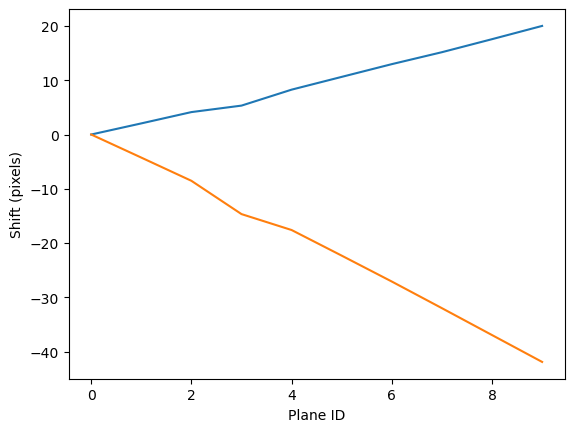

In [36]:
plt.plot(summary['plane_shifts'])
plt.xlabel("Plane ID")
plt.ylabel("Shift (pixels)")

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x249bb91e940>)

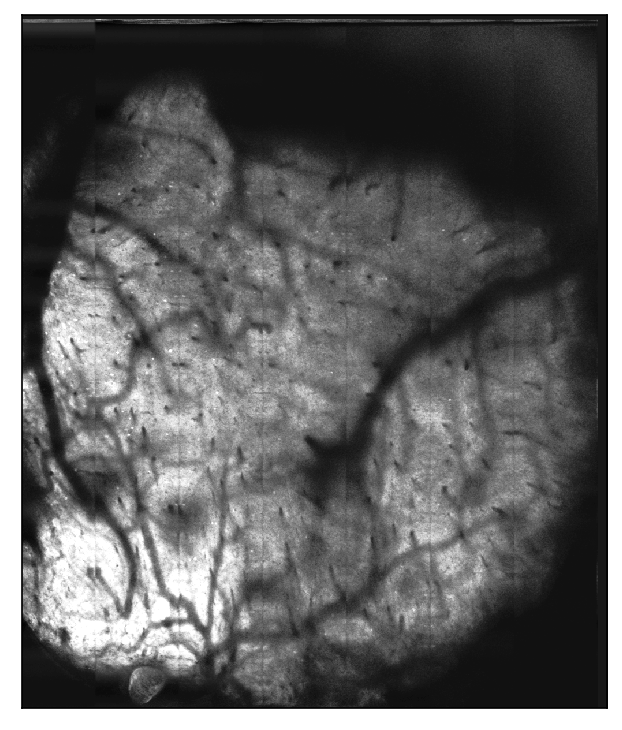

In [37]:
# This is the "Reference Image" that all frames will be registered to.
# Check to see how this compares to the image plotted above (tfu.show_tif(im3d[9]))
# You should notice two things that are different:
# 1. this image is shifted in xy by the plane shifts calculated in the plot above
# 2. this image is less noisy and higher quality, because it is an average of frames that were
# registered to each other

# Notice the index, this is plane 4 in this job because we set the job_params['planes'] parameter 
# to only analyze planes 5,6,7,8,9. So, plane 4 in this job actually corresponds to plane 9 in the 
# original stack. 
tfu.show_tif(summary['ref_img_3d'][4])

## Registration

In [41]:
job.register(job.tifs[:30], start_batch_idx=0)

Will analyze 30 tifs in 30 batches
   Launching IO thread
         Start Batch:        Total Used: 055.565 GB, Virtual: 049.214 GB, Swap: 006.351
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif
Loading Batch 1 of 30
   Loaded 1 files, total 2.27 GB
   Batch 0 IO thread joined
         After IO thread joinTotal Used: 057.925 GB, Virtual: 051.575 GB, Swap: 006.351
         After Sharr creation:Total Used: 060.205 GB, Virtual: 053.854 GB, Swap: 006.351
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.205 GB, Virtual: 053.854 GB, Swap: 006.351
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00002.tif
   Registering Batch 0
         Before Reg:         Total Used: 060.208 GB, Virtual: 053.868 GB, Swap: 006.340
   
      Registering plane 0
      Registering plane 1
      Registering plane 2
   Loaded 1 files, total 2.27 GB
      Registering plane 3
      Registering plane 4
      Regis

      Registering plane 1
      Registering plane 2
      Registering plane 3
      Registering plane 4
      Registering plane 5
      Registering plane 6
      Registering plane 7
      Registering plane 8
      Registering plane 9
   Loaded 1 files, total 2.27 GB
      Saving registered file to Y:\analysis\example\s3d-test_experiment_002\registered_data\reg_data0006.npy
         After reg:          Total Used: 060.236 GB, Virtual: 053.755 GB, Swap: 006.480
      Garbage collected 3516 items
         After gc collect:   Total Used: 060.236 GB, Virtual: 053.755 GB, Swap: 006.480
         Start Batch:        Total Used: 060.236 GB, Virtual: 053.755 GB, Swap: 006.480
Loading Batch 8 of 30
   Batch 7 IO thread joined
         After IO thread joinTotal Used: 060.236 GB, Virtual: 053.755 GB, Swap: 006.480
         After Sharr creation:Total Used: 060.238 GB, Virtual: 053.762 GB, Swap: 006.477
   Launching IO thread for next batch
         After IO thread launch:Total Used: 060.238 GB, Virt

         After Sharr creation:Total Used: 059.331 GB, Virtual: 034.881 GB, Swap: 024.449
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.331 GB, Virtual: 034.881 GB, Swap: 024.449
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00015.tif
   Registering Batch 13
         Before Reg:         Total Used: 059.338 GB, Virtual: 034.882 GB, Swap: 024.455
   
      Registering plane 0
      Registering plane 1
      Registering plane 2
      Registering plane 3
      Registering plane 4
      Registering plane 5
      Registering plane 6
      Registering plane 7
      Registering plane 8
      Registering plane 9
   Loaded 1 files, total 2.27 GB
      Saving registered file to Y:\analysis\example\s3d-test_experiment_002\registered_data\reg_data0013.npy
         After reg:          Total Used: 059.432 GB, Virtual: 035.366 GB, Swap: 024.066
      Garbage collected 3516 items
         After gc collect:   Total Used: 059.431 GB, 

      Registering plane 8
      Registering plane 9
   Loaded 1 files, total 2.27 GB
      Saving registered file to Y:\analysis\example\s3d-test_experiment_002\registered_data\reg_data0019.npy
         After reg:          Total Used: 059.552 GB, Virtual: 035.841 GB, Swap: 023.711
      Garbage collected 3516 items
         After gc collect:   Total Used: 059.552 GB, Virtual: 035.841 GB, Swap: 023.711
         Start Batch:        Total Used: 059.552 GB, Virtual: 035.841 GB, Swap: 023.711
Loading Batch 21 of 30
   Batch 20 IO thread joined
         After IO thread joinTotal Used: 059.552 GB, Virtual: 035.841 GB, Swap: 023.711
         After Sharr creation:Total Used: 059.552 GB, Virtual: 035.843 GB, Swap: 023.709
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.552 GB, Virtual: 035.844 GB, Swap: 023.708
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00022.tif
   Registering Batch 20
         Before Reg:         Total Us

         After Sharr creation:Total Used: 059.634 GB, Virtual: 036.223 GB, Swap: 023.411
   Launching IO thread for next batch
         After IO thread launch:Total Used: 059.634 GB, Virtual: 036.223 GB, Swap: 023.411
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00028.tif
   Registering Batch 26
         Before Reg:         Total Used: 059.638 GB, Virtual: 036.223 GB, Swap: 023.416
   
      Registering plane 0
      Registering plane 1
      Registering plane 2
      Registering plane 3
      Registering plane 4
      Registering plane 5
      Registering plane 6
      Registering plane 7
      Registering plane 8
   Loaded 1 files, total 2.27 GB
      Registering plane 9
      Saving registered file to Y:\analysis\example\s3d-test_experiment_002\registered_data\reg_data0026.npy
         After reg:          Total Used: 059.645 GB, Virtual: 036.449 GB, Swap: 023.196
      Garbage collected 3516 items
         After gc collect:   Total Used: 059.645 GB, 

In [39]:
# get a memory-mapped version of the registered movie
# This DOESNT load everythin into memory, it's a Dask array
registered_movie = job.get_registered_movie()

## Fuse registered files
It's good to get rid of the strip artifacts before computing the correlation map and moving on to cell detection. Use `fuse_registered_movie` on a subset of files without saving to figure out the best parameters, and then call it on the whole dataset. The two parameters of fusing are:
```
n_shift (int): number of pixels of overlap (how many pixels on the right border of strip 1 are repeated on the left border of strip 2, ignoring the dark pixels between the strips)
n_buf (int): number of dark pixels between strips
```

Keep in mind it's not fully uniform over the full field of view, but it's good enough

In [7]:
files = job.get_registered_files()

In [8]:
mov = job.get_registered_movie()

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x18697215c40>)

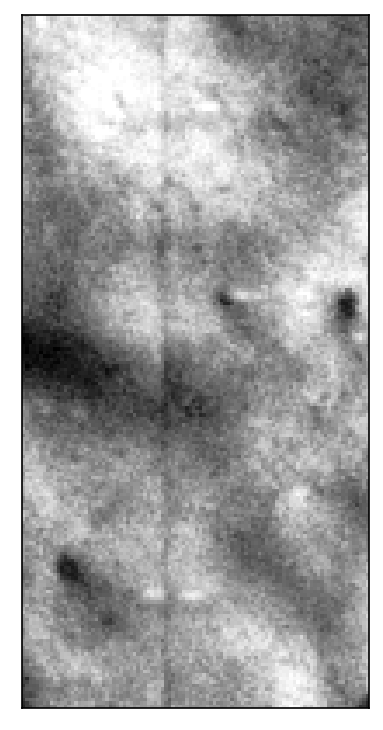

In [10]:
tfu.show_tif(mov[0,:200,600:800,100:200].mean(axis=0).compute())

In [11]:
fused = job.fuse_registered_movie(n_shift=11,n_buf=2,files=files[:2])

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x18697235460>)

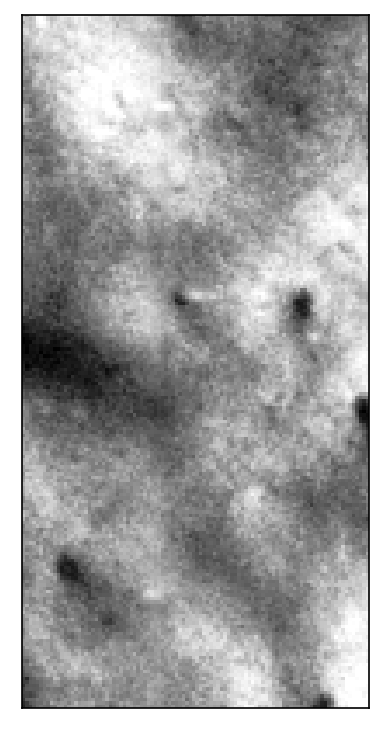

In [12]:
tfu.show_tif(fused[0,:500,600:800,100:200].mean(axis=0))

In [13]:
# Now that we found the right parameters, fuse all files and save fused files to the job directory
# This will return a list of files instead of a full movie
fused = job.fuse_registered_movie(n_shift=11,n_buf=2,save=True,n_proc = 8)

In [ ]:
# now you can load the registered & fused movie:
registered_movie = job.get_registered_movie(key='registered_fused_data', filename_filter='')